## Odds ratio on high fire danger days during low sea salt years

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from pathlib import Path
import scipy
import dask

%matplotlib inline

In [2]:
#geospatial plots
from rasterstats import zonal_stats
import rasterio
import os
import geopandas as gpd

In [3]:
#load netcdf - calculated in Paper3_high_fire_danger_daily_counts_percentiles_90th_75th.ipynb
FFDI_extreme_90th_count = xr.open_dataset('/g/data/v45/du2523/FFDI_condition_counts/no_extreme_days_ab_90th_perc_NDJF_SEA.nc')
#FFDI_extreme_75th_count = xr.open_dataset('/g/data/v45/du2523/FFDI_condition_counts/no_extreme_days_ab_75th_perc_NDJF_SEA.nc')

In [4]:
shpfile = gpd.read_file('/g/data1a/v45/du2523/shp_files/ESB_lines_ACT_and_VicAlps_added_Hunter_Lakes_Entrance_valid_geometry.shp')
#remove none rows
shp = shpfile
shp = shp[shp.geom_type == 'MultiPolygon']
shp

,Id,Name,geometry
0,1,ESB2,"MULTIPOLYGON (((147.96109 -37.89161, 147.94878..."


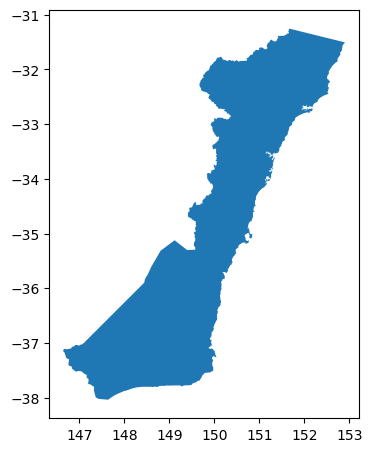

In [6]:
fig, ax = plt.subplots(figsize = (4,8))
shp.plot(ax = ax)
plt.show()

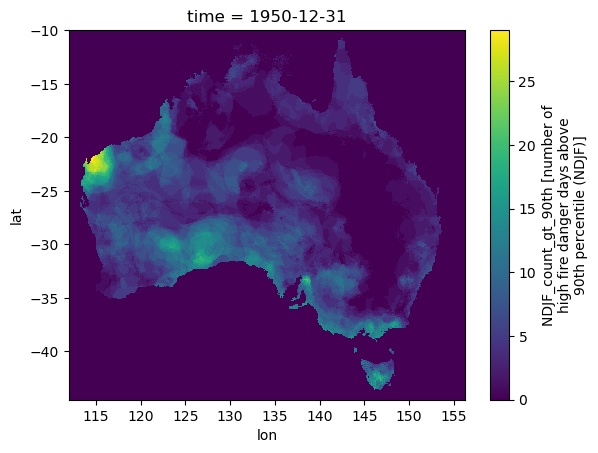

In [7]:
#seasonal count dataset December year 
FFDI_extreme_90th_count.NDJF_count_gt_90th.sel(time = '1950-12-31').plot()

In [8]:
#select date periods. Tercile years from 1950-2016
#the LDsss concentration threshold of 0.05 µ Eq L-1 (LDsss lower tercile 1950-2016) was used to classify low (<0.05 µ Eq L-1) and non-low (≥ 0.05 µ Eq L-1) sea-salt concentration seasons

#LDsss < 0.05 (low tercile 1950-2016)
high_tercile_sea_salt_dates = ['1950-12-31','1951-12-31','1956-12-31','1961-12-31','1962-12-31','1963-12-31', '1965-12-31', 
                       '1966-12-31', '1971-12-31', '1974-12-31', '1981-12-31', '1983-12-31', '1987-12-31', '1988-12-31', 
                       '1991-12-31', '1994-12-31', '1998-12-31', '2001-12-31', '2007-12-31', '2009-12-31', '2010-12-31', 
                       '2011-12-31', '2015-12-31']

low_tercile_sea_salt_dates = ['1958-12-31','1964-12-31','1967-12-31','1968-12-31','1969-12-31','1972-12-31', '1976-12-31', 
                       '1977-12-31', '1979-12-31', '1982-12-31', '1985-12-31', '1986-12-31', '1989-12-31', '1992-12-31', 
                       '1993-12-31', '2000-12-31', '2003-12-31', '2004-12-31', '2008-12-31', '2012-12-31', '2013-12-31', 
                       '2014-12-31']

mid_tercile_sea_salt_dates = ['1952-12-31','1953-12-31','1954-12-31','1955-12-31','1957-12-31','1959-12-31', '1960-12-31', 
                       '1970-12-31', '1973-12-31', '1975-12-31', '1978-12-31', '1980-12-31', '1984-12-31', '1990-12-31', 
                       '1995-12-31', '1996-12-31', '1997-12-31', '1999-12-31', '2002-12-31', '2005-12-31', '2006-12-31']

#LDsss <0.06 (incorporates 2003) - checking sensitivity
low_tercile_sea_salt_dates_extra3 = ['1958-12-31','1964-12-31','1967-12-31','1968-12-31','1969-12-31','1972-12-31', '1976-12-31', 
                       '1977-12-31', '1979-12-31', '1982-12-31', '1985-12-31', '1986-12-31', '1989-12-31', '1992-12-31', 
                       '1993-12-31', '2000-12-31', '2003-12-31', '2004-12-31', '2008-12-31', '2012-12-31', '2013-12-31', 
                       '2014-12-31', '1997-12-31', '1996-12-31', '2002-12-31']

mid_tercile_sea_salt_dates_minus3 = ['1952-12-31','1953-12-31','1954-12-31','1955-12-31','1957-12-31','1959-12-31', '1960-12-31', 
                       '1970-12-31', '1973-12-31', '1975-12-31', '1978-12-31', '1980-12-31', '1984-12-31', '1990-12-31', 
                       '1995-12-31', '1999-12-31', '2005-12-31', '2006-12-31']

## Odds ratio - 90th percentile FFDI - low sea salt years

In [9]:
#Low sea salt condition test 
#y1 = seasonal count array = number of days meeting condition
#n1 = number of days in each season -> 120 days x number of years (not including leap years)

#a = FFDI_veryhigh_count.seasonal_count
a = FFDI_extreme_90th_count.NDJF_count_gt_90th

low_sea_salt = a.sel(time = low_tercile_sea_salt_dates) #<0.05
y1 = low_sea_salt.sum(dim = 'time') #cumulative sum of high fire danger days over threshold. 
n1 = len(low_sea_salt)*120 #number of days in seasons over threshold. Len returns the number of season. 120 days in each season (excluding leap years). 
z1 = n1 - y1 #number of non extreme days in low sea salt years
#y1.plot()

#y2 = seasonal count array of all other years
#n2 = number of days in each season -> 120 days x number of years

#concatenate mid and lower dates
non_low_sea_salt_dates = high_tercile_sea_salt_dates + mid_tercile_sea_salt_dates
non_low_sea_salt = a.sel(time = non_low_sea_salt_dates)
y2 = non_low_sea_salt.sum(dim = 'time')
n2 = len(non_low_sea_salt_dates)*120
z2 = n2 - y2 #number of non extreme days in non low sea salt years


#odds ratio
odd_lss = y1/z1
odds_other = y2/z2
oddsratio90 = odd_lss/odds_other

### proportion test
#
p1 = y1/n1
p2 = y2/n2
prop = (y1+y2)/(n1+n2)
p1_p2 = p1/p2

#calculate z value
numer = abs(p1 - p2)
deriv = prop * (1-prop) * ((1/n1)+(1/n2))
#deriv
deriv2 = np.sqrt(deriv)
zvalue = numer/ deriv2

#calculate p value
from scipy.stats import norm
NormP = norm.cdf(zvalue,loc = 0, scale = 1)
pvalue = 1 - NormP

## Odds ratio plot - Figure 2a

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


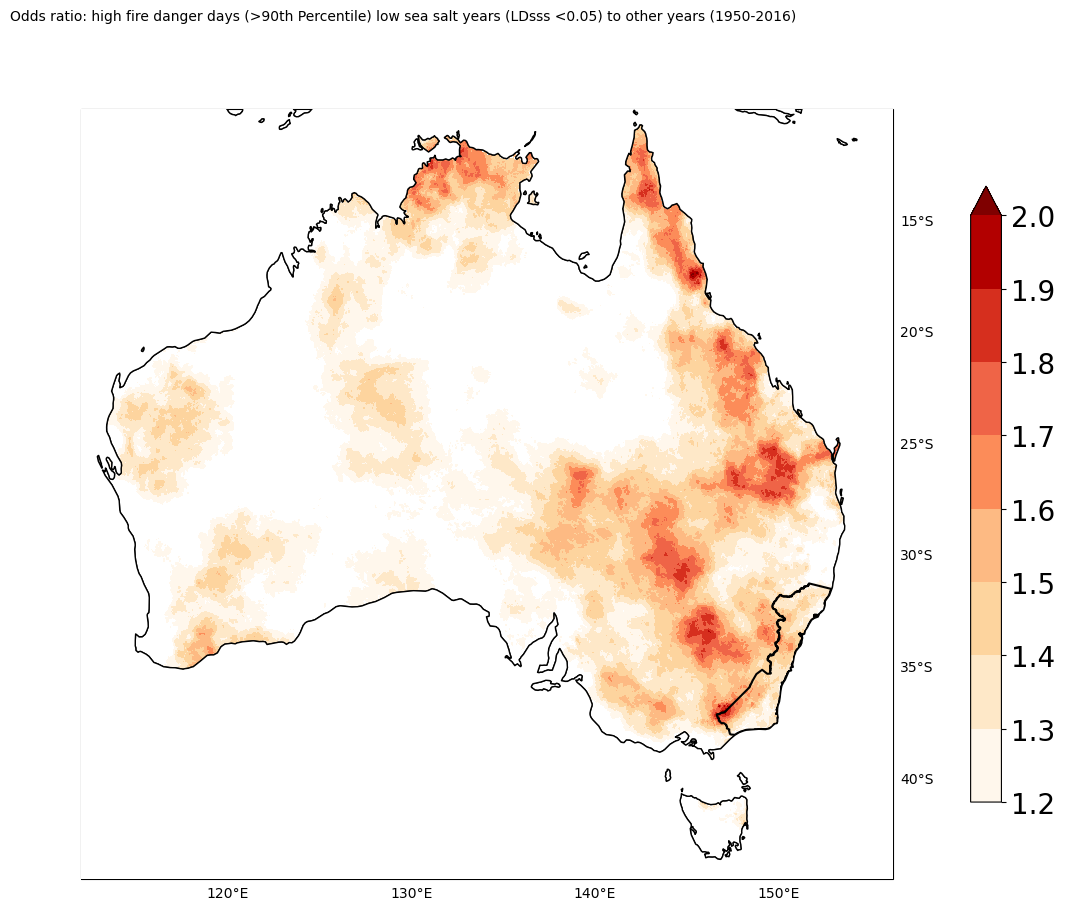

In [10]:
#Odds ratio plot - Figure 2a
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value 
#levels = np.arange(1.2,2.6,0.2) #p1/p2 value 
levels = np.arange(1.2,2.1,0.1) #p1/p2 value 
#ID = 'LDsss_FFDI_corr_sig'
var = 'LDsss'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_odds_ratio_low_sea_salt_LDsss_ls0.05_lowertercile_1950-2016'
region = 'Aus_shp_file'

#either corr or dcorr

cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

shp.plot(ax = ax, color = 'none', edgecolor = 'black', linewidth = 1.5)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) low sea salt years (LDsss <0.05) to other years (1950-2016)',fontsize = 10)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')